In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
'''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

In [15]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import random
import IPython.display as ipd
from glob import glob

# Define paths (edit based on your environment)
base_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
train_path = os.path.join(base_path, "training")
val_path = os.path.join(base_path, "validation")
test_path = os.path.join(base_path, "testing")

In [16]:
## Visualizing the dataset playing any random audio

def get_file_paths(folder):
    return glob(os.path.join(folder, "**", "*.wav"), recursive=True)

# Load one audio file for visualization
all_train_files = get_file_paths(train_path)
random_audio_file = random.choice(all_train_files)
print("Sample audio:", random_audio_file)

# Load with Librosa
signal, sr = librosa.load(random_audio_file, sr=32000)  # Target SR = 32kHz
print(f"Audio Duration: {len(signal)/sr:.2f} seconds, Sample Rate: {sr}")

# Play audio
ipd.Audio(signal, rate=sr)

Sample audio: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/fake/file11485.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav
Audio Duration: 1.19 seconds, Sample Rate: 32000


In [ ]:
from pathlib import Path
import pandas as pd

DATASET_PATH = Path("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm")

def get_file_paths_and_labels(split_folder):
    split_path = DATASET_PATH / split_folder
    filepaths, labels = [], []
    
    for label in ['real', 'fake']:
        label_path = split_path / label
        #print(label_path)
        if not label_path.exists():
            continue
        for wav_file in label_path.glob("*.wav"):
            #print(wav_file)
            filepaths.append(str(wav_file))
            labels.append(label)
    
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

# Reload using corrected path
train_df = get_file_paths_and_labels("training")
val_df = get_file_paths_and_labels("validation")
test_df = get_file_paths_and_labels("testing")

# Check contents
## training shape
print("Train shape:", train_df.shape)
print(train_df['label'].value_counts())

print()
# validation shape
print("Validation shape:", val_df.shape)
print(val_df['label'].value_counts())

print()
# test shape
print("Testing shape:", test_df.shape)
print(test_df['label'].value_counts())

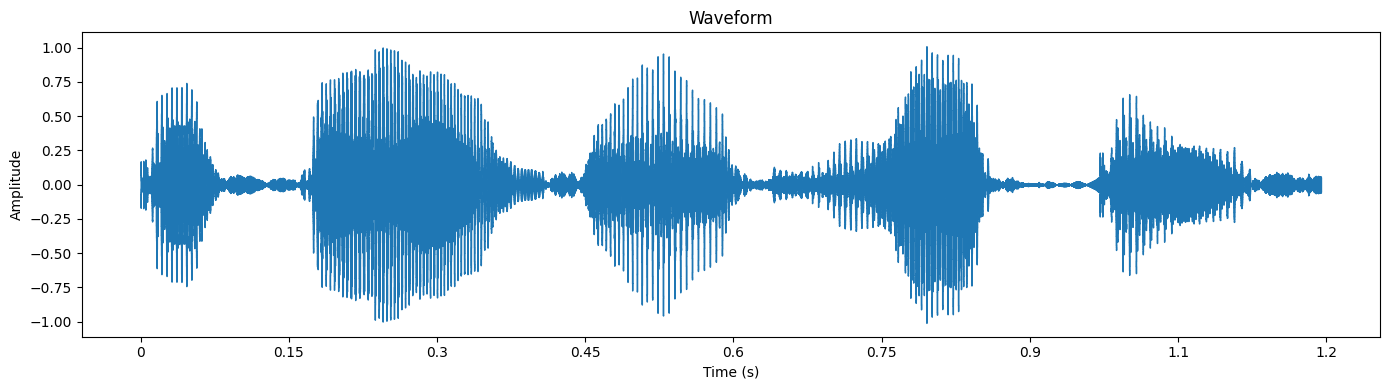

In [18]:
## waveform visualization

plt.figure(figsize=(14, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

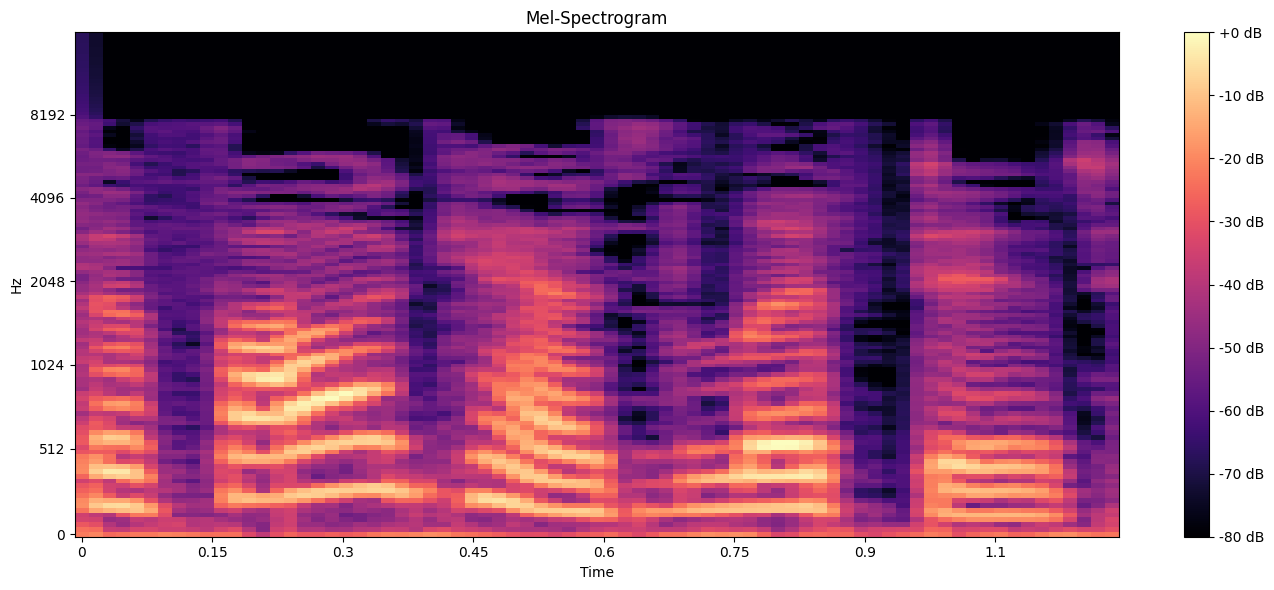

In [20]:
## Mel spectogram visualization

mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=16000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=16000)
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [21]:
## Data Preprocessing
import torchaudio
import librosa
import os
import numpy as np
import torch

SAMPLE_RATE = 32000

def preprocess_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(waveform)
    waveform = waveform.mean(dim=0, keepdim=True)  # Mono
    return waveform

def get_melspectrogram(waveform):
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_mels=128
    )(waveform)
    return torchaudio.transforms.AmplitudeToDB()(mel_spec)

In [24]:
## Model defintion

import timm
import torch.nn as nn

class PaSSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.passt = timm.create_model("hf_hub:timm/PaSST_S_k400", pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.passt(x)
        return self.head(x)


In [25]:
## Training loop

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix

# Custom Dataset (simplified)
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform = preprocess_audio(self.file_paths[idx])
        mel = get_melspectrogram(waveform)
        return mel, self.labels[idx]

# Training function
def train(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.cuda(), y.cuda()
            out = model(X)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [3]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 32.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 85.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [1]:
!pip install hear21passt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [4]:
import os
import torch
import torchaudio
import timm
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gradio as gr
from hear21passt.base import get_basic_model, get_model_passt
from torch.optim import AdamW
from collections import defaultdict

In [5]:
# ----------- CONFIG ----------- 
SAMPLE_RATE = 32000
N_MELS = 128
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ----------- DATA LOADER (UPDATED) -----------
class AudioDataset(Dataset):
    def __init__(self, file_list, max_length=512):
        self.file_list = file_list
        self.max_length = max_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        try:
            waveform, _ = torchaudio.load(file_path)
            waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono
            
            mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=SAMPLE_RATE, n_mels=N_MELS)(waveform)
            mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
            
            # Pad or truncate to fixed length
            if mel_spec_db.size(-1) < self.max_length:
                pad_amt = self.max_length - mel_spec_db.size(-1)
                mel_spec_db = torch.nn.functional.pad(mel_spec_db, (0, pad_amt))
            else:
                mel_spec_db = mel_spec_db[:, :, :self.max_length]
            
            return mel_spec_db, label
            
        except Exception as e:
            print(f'Skipping Corrupted file {idx}')
            return None
             
             
        


In [7]:
## MODEL

# ----------- MODEL -----------
class PaSSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = get_basic_model(mode="logits")
        self.backbone.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=512)  # Use default output size
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,2),
        )

    def forward(self, x):
        x, _ = self.backbone.net(x)
        x = self.mlp(x)
        return x

In [31]:
from tqdm import tqdm
# ----------- TRAINING -----------
def train(model, train_loader, val_loader, epochs=10):
    model = model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for mel, label in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            if mel is None:
                continue
            mel, label = mel.to(DEVICE), label.to(DEVICE)
            output = model(mel)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")
        print()
        print('validation confusion matrix')
        evaluate(model, val_loader)
        print()
        print('testing confusion matrix')
        evaluate(model, test_loader)
        print()
        print('####################### Saving the model after every epoch  #########################')
        torch.save(model.state_dict(), "/kaggle/working/passt_weights_10000.pth")

In [22]:
# ----------- EVALUATION -----------
def evaluate(model, dataloader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for mel, label in dataloader:
            mel = mel.to(DEVICE)
            out = model(mel)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(label.numpy())
    print(classification_report(targets, preds))
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.show()

In [23]:
# ----------- t-SNE VISUALIZATION -----------
def tsne_embeddings(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for mel, label in dataloader:
            mel = mel.to(DEVICE)
            feats, _ = model.backbone.net.forward_features(mel)
            features.append(feats.cpu().numpy())
            labels += label.numpy().tolist()
    features = np.vstack(features)
    tsne = TSNE(n_components=2).fit_transform(features)
    plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='coolwarm')
    plt.title("t-SNE of Embeddings")
    plt.show()

In [24]:
# ----------- REAL-TIME MIC INFERENCE -----------
def predict_mic(audio_path):
    model.eval()
    waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    waveform = torch.tensor(waveform).unsqueeze(0)
    mel = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=N_MELS)(waveform)
    mel = torchaudio.transforms.AmplitudeToDB()(mel)
    mel = mel.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(mel)
    return "REAL" if output.argmax(1).item() == 0 else "FAKE"

In [13]:
# ----------- GRADIO UI -----------
iface = gr.Interface(fn=predict_mic, inputs=gr.Audio(type="filepath", label="Mic Input"), outputs="text")


In [25]:
# ----------- MAIN EXECUTION (Dataset from for-norm) -----------
def load_dataset(split_dir):
    file_list = []
    for label_name in ["real", "fake"]:
        label = 0 if label_name == "real" else 1
        path = os.path.join(split_dir, label_name)
        for fname in os.listdir(path):
            if fname.endswith(".wav"):
                file_list.append((os.path.join(path, fname), label))
    return file_list

def balanced_sample(file_list, total_samples):
    label_to_files = defaultdict(list)
    for path, label in file_list:
        label_to_files[label].append((path, label))

    per_class = total_samples // 2
    sampled = []
    for label in [0, 1]:
        sampled.extend(random.sample(label_to_files[label], min(per_class, len(label_to_files[label]))))
    return sampled

In [26]:

base_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
train_list = load_dataset(os.path.join(base_path, "training"))
val_list = load_dataset(os.path.join(base_path, "validation"))
test_list = load_dataset(os.path.join(base_path, "testing"))

In [27]:
import random
## selecting random samples
random.seed(42)
train_list = balanced_sample(train_list, 5000)
val_list = balanced_sample(val_list, 1000)
test_list = balanced_sample(test_list, 1000)

In [28]:
train_dataset = AudioDataset(train_list)
val_dataset = AudioDataset(val_list)
test_dataset = AudioDataset(test_list)

In [29]:
def safe_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
         return None  # Avoid batch of only corrupted data
    return torch.utils.data.dataloader.default_collate(batch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn = safe_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn = safe_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn = safe_collate)

In [19]:
model = PaSSTClassifier()



 Loading PASST TRAINED ON AUDISET 




100%|██████████| 329M/329M [00:03<00:00, 95.9MB/s] 
/usr/local/lib/python3.11/dist-packages/hear21passt/models/helpers/vit_helpers.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

Epoch 1:  30%|███       | 94/313 [03:27<08:31,  2.33s/it]

Skipping Corrupted file 1498


Epoch 1: 100%|██████████| 313/313 [12:12<00:00,  2.34s/it]


Epoch 1, Loss: 0.1693

validation confusion matrix
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       500
           1       0.98      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



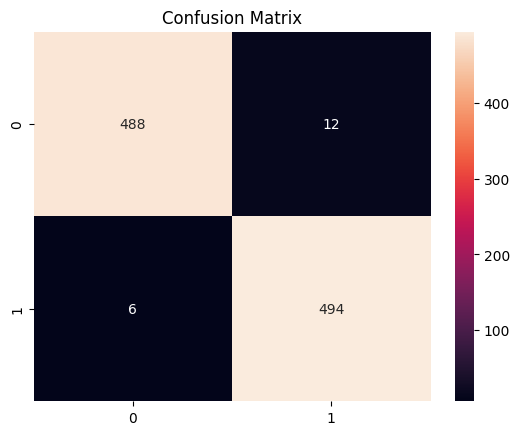


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.73      0.86      0.79       500
           1       0.83      0.69      0.75       500

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000



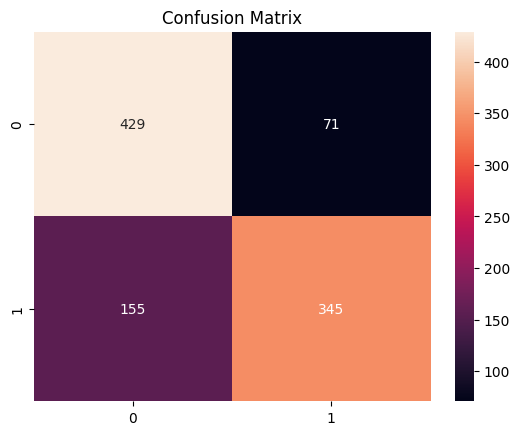


####################### Saving the model after every epoch  #########################


Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 2:  69%|██████▉   | 216/313 [08:28<03:48,  2.36s/it]

Skipping Corrupted file 1498


Epoch 2: 100%|██████████| 313/313 [12:15<00:00,  2.35s/it]


Epoch 2, Loss: 0.0702

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



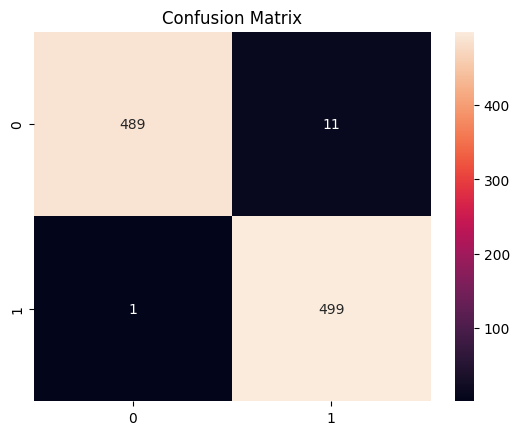


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.70      0.86      0.77       500
           1       0.82      0.62      0.71       500

    accuracy                           0.74      1000
   macro avg       0.76      0.74      0.74      1000
weighted avg       0.76      0.74      0.74      1000



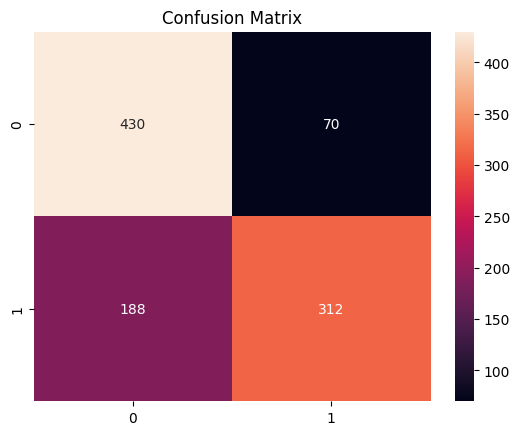


####################### Saving the model after every epoch  #########################


Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 3:  36%|███▌      | 112/313 [04:22<07:50,  2.34s/it]

Skipping Corrupted file 1498


Epoch 3: 100%|██████████| 313/313 [12:16<00:00,  2.35s/it]


Epoch 3, Loss: 0.0401

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



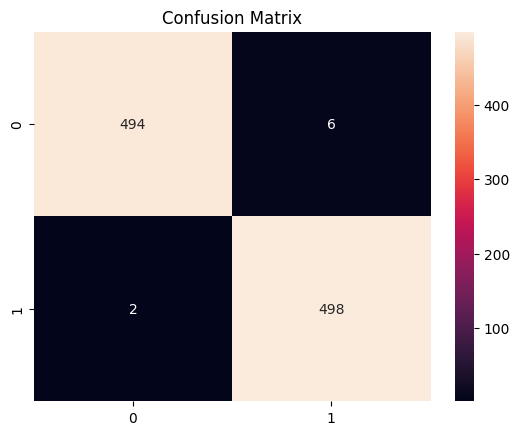


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.59      0.94      0.72       500
           1       0.84      0.34      0.48       500

    accuracy                           0.64      1000
   macro avg       0.72      0.64      0.60      1000
weighted avg       0.72      0.64      0.60      1000



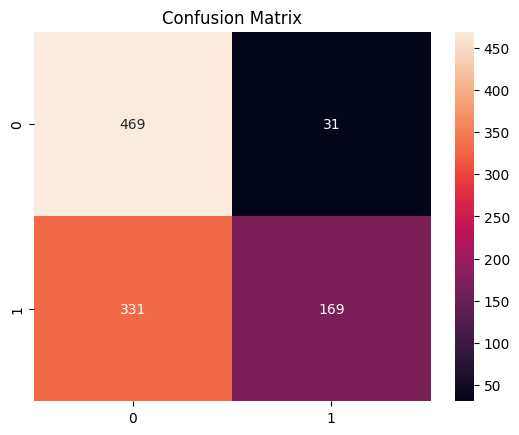


####################### Saving the model after every epoch  #########################


Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 4:  51%|█████▏    | 161/313 [06:17<05:57,  2.35s/it]

Skipping Corrupted file 1498


Epoch 4: 100%|██████████| 313/313 [12:15<00:00,  2.35s/it]


Epoch 4, Loss: 0.0187

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       500
           1       0.95      1.00      0.98       500

    accuracy                           0.97      1000
   macro avg       0.98      0.97      0.97      1000
weighted avg       0.98      0.97      0.97      1000



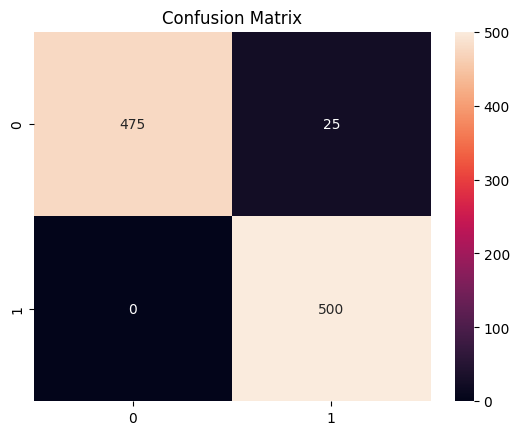


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.89      0.57      0.69       500
           1       0.68      0.93      0.79       500

    accuracy                           0.75      1000
   macro avg       0.79      0.75      0.74      1000
weighted avg       0.79      0.75      0.74      1000



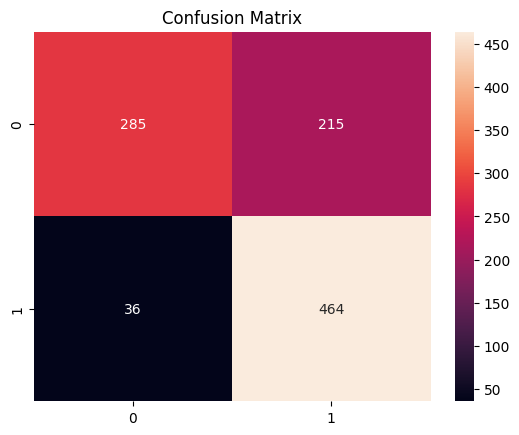


####################### Saving the model after every epoch  #########################


Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 5:   6%|▌         | 18/313 [00:42<11:31,  2.34s/it]

Skipping Corrupted file 1498


Epoch 5: 100%|██████████| 313/313 [12:16<00:00,  2.35s/it]


Epoch 5, Loss: 0.0276

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



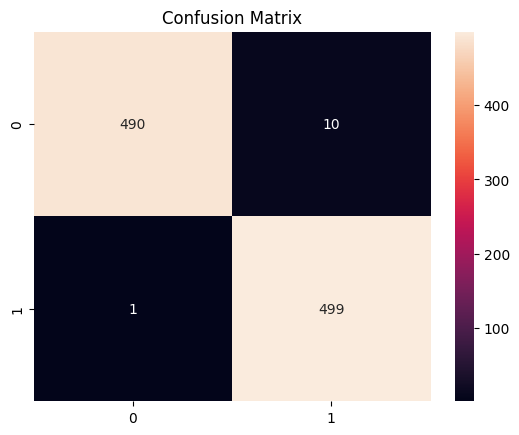


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.65      0.91      0.76       500
           1       0.85      0.52      0.64       500

    accuracy                           0.71      1000
   macro avg       0.75      0.71      0.70      1000
weighted avg       0.75      0.71      0.70      1000



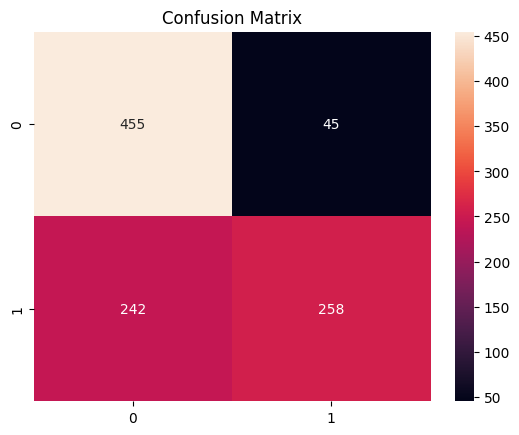


####################### Saving the model after every epoch  #########################


Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 6:  14%|█▍        | 44/313 [01:42<10:27,  2.33s/it]

Skipping Corrupted file 1498


Epoch 6: 100%|██████████| 313/313 [12:17<00:00,  2.35s/it]


Epoch 6, Loss: 0.0179

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      1.00       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



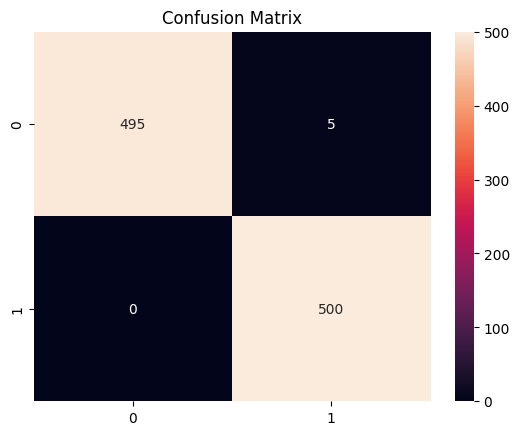


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.56      0.93      0.70       500
           1       0.80      0.27      0.41       500

    accuracy                           0.60      1000
   macro avg       0.68      0.60      0.55      1000
weighted avg       0.68      0.60      0.55      1000



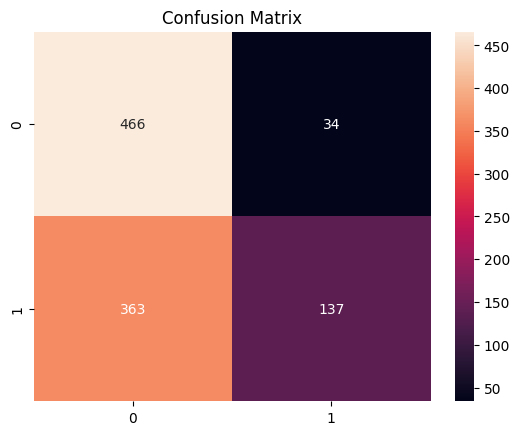


####################### Saving the model after every epoch  #########################


Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 7:  39%|███▉      | 122/313 [04:47<07:31,  2.36s/it]

Skipping Corrupted file 1498


Epoch 7: 100%|██████████| 313/313 [12:17<00:00,  2.36s/it]


Epoch 7, Loss: 0.0256

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



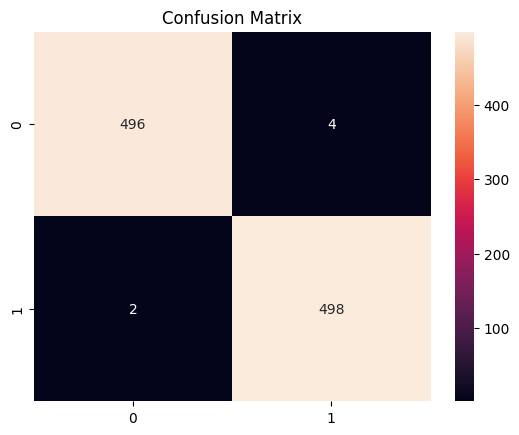


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.63      0.91      0.75       500
           1       0.84      0.47      0.60       500

    accuracy                           0.69      1000
   macro avg       0.74      0.69      0.67      1000
weighted avg       0.74      0.69      0.67      1000



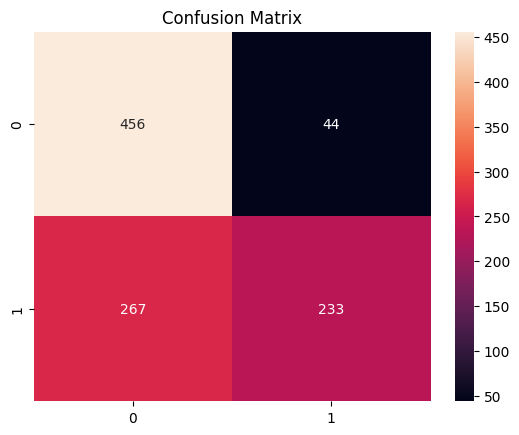


####################### Saving the model after every epoch  #########################


Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 8:  62%|██████▏   | 194/313 [07:37<04:41,  2.36s/it]

Skipping Corrupted file 1498


Epoch 8: 100%|██████████| 313/313 [12:20<00:00,  2.37s/it]


Epoch 8, Loss: 0.0004

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       500
           1       0.97      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



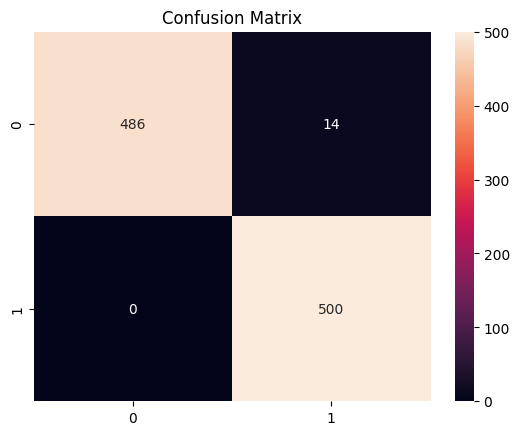


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.75      0.76      0.75       500
           1       0.75      0.75      0.75       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



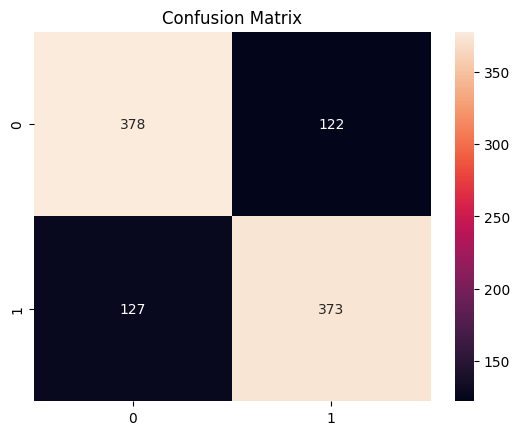


####################### Saving the model after every epoch  #########################


Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 9:   7%|▋         | 22/313 [00:53<11:43,  2.42s/it]

Skipping Corrupted file 1498


Epoch 9: 100%|██████████| 313/313 [12:33<00:00,  2.41s/it]


Epoch 9, Loss: 0.0001

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



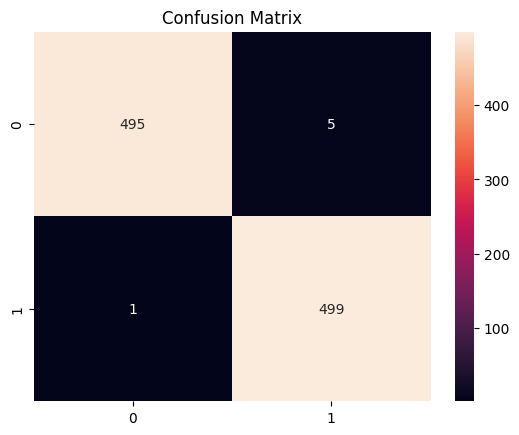


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.65      0.90      0.75       500
           1       0.83      0.51      0.63       500

    accuracy                           0.70      1000
   macro avg       0.74      0.70      0.69      1000
weighted avg       0.74      0.70      0.69      1000



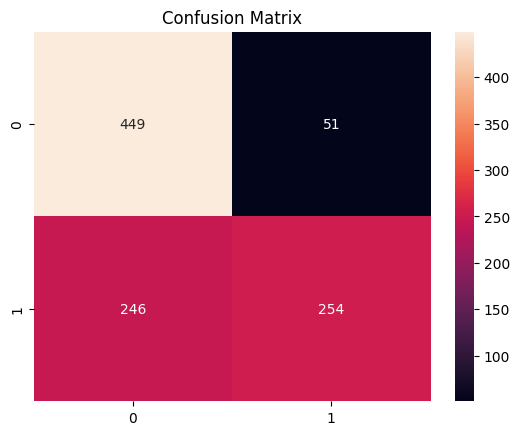


####################### Saving the model after every epoch  #########################


Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 10:  66%|██████▌   | 206/313 [08:17<04:20,  2.43s/it]

Skipping Corrupted file 1498


Epoch 10: 100%|██████████| 313/313 [12:35<00:00,  2.41s/it]


Epoch 10, Loss: 0.0000

validation confusion matrix
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      1.00       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



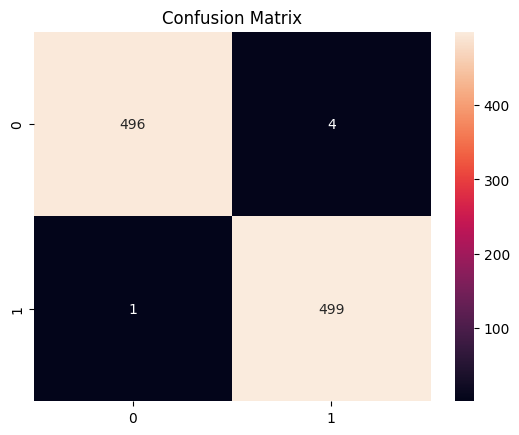


testing confusion matrix


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.64      0.90      0.75       500
           1       0.84      0.50      0.63       500

    accuracy                           0.70      1000
   macro avg       0.74      0.70      0.69      1000
weighted avg       0.74      0.70      0.69      1000



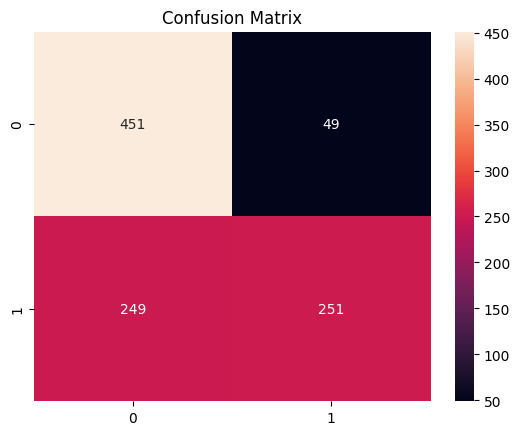


####################### Saving the model after every epoch  #########################


In [32]:
train(model, train_loader, val_loader, epochs=10)
torch.save(model.state_dict(), "/kaggle/working/passt_weights_10000.pth")

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


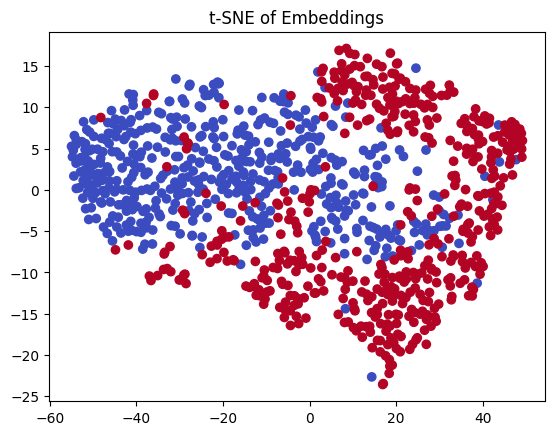

In [33]:
tsne_embeddings(model, test_loader)

In [41]:
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://bda02b71695946d9ec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2146, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1664, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
           ^^^^^^^^^^

Created dataset file at: .gradio/flagged/dataset1.csv


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2146, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1664, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
           ^^^^^^^^^^